In [2]:
from constants import *
from inject_noise import *

In [8]:
n_channels = 22

data_path = '/Users/seonghyunyoon/Developer/cp-eeg/Data/2aiv/'
save_path = '/Users/seonghyunyoon/Developer/conformal_prediction_bmi/test 5 (noise)/'
model_path = f'/Users/seonghyunyoon/Developer/conformal_prediction_bmi/test 1 (ideal)//saved_models/'

In [7]:
all_X_train = []; all_y_train = []; all_X_val = []; all_y_val = []; all_X_test = []; all_y_test = []

all_models = [] 

for subject_num in tqdm(range(1, 10)): 
    # Load data 
    X_train, y_train = get_data(subject_num, training=True, path=data_path)
    X_val_test, y_val_test = get_data(subject_num, training=False, path=data_path)
    X_train, y_train = prepare_features(X_train, y_train)
    X_val_test, y_val_test = prepare_features(X_val_test, y_val_test)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size=.65, random_state=42)
    
    # Scale the data
    for j in range(n_channels):
        scaler = StandardScaler()
        scaler.fit(X_train[:,0,j,:])
        X_train[:,0,j,:] = scaler.transform(X_train[:,0,j,:])
        X_val[:,0,j,:] = scaler.transform(X_val[:,0,j,:])
        X_test[:,0,j,:] = scaler.transform(X_test[:,0,j,:])
    
    # Append to total data 
    all_X_train.append(X_train)
    all_y_train.append(y_train)
    all_X_val.append(X_val)
    all_y_val.append(y_val)
    all_X_test.append(X_test)
    all_y_test.append(y_test)
    
    # Prepare model
    curr_model_path = f'{model_path}/model_{subject_num}.h5'
    _, _, n_channels, n_time = X_train.shape
    n_classes = y_train.shape[1]
    model = EEGTCNet(nb_classes = n_classes, Chans=n_channels, Samples=n_time, layers=L, kernel_s=KT, filt=FT, dropout=pt, activation='elu', 
                     F1=F1, D=2, kernLength=KE, dropout_eeg=pe)
    model.load_weights(curr_model_path)
    all_models.append(model)

  0%|          | 0/9 [00:00<?, ?it/s]

## P values

0.337391672911327

In [429]:
np.max(np.abs(all_X_train[0])) * 0.05 * 2

0.6452065176518875

In [449]:
np.random.seed(42)
from scipy.stats import kstest

strengths = [.05, .15, .25]
noise_types = ["gaussian", "impulse", "motion"]
noise_funs = [add_gaussian_noise, add_impulse_noise, add_motion_artifacts]
sample_percentages = np.arange(0.01, 1.01, 0.01)
n_iters = 100
n_subjects = 9

pvalues = np.zeros((len(strengths), len(noise_types), n_subjects, len(sample_percentages), n_iters))
for i0, strength in tqdm(enumerate(strengths), total=3): 
    for i1, noise_fun in tqdm(enumerate(noise_funs), total=3): 
        for n_subject in range(n_subjects): 
            model = all_models[n_subject]
            X_val = all_X_val[n_subject]; y_val = all_y_val[n_subject]
            X_test = all_X_test[n_subject]; y_test = all_y_test[n_subject]
            X_test_noisy = noise_fun(X_test, strength=strength)
            val_smx = model.predict(X_val, verbose=False); test_smx = model.predict(X_test_noisy, verbose=False)
            n_test = X_test_noisy.shape[0]
            for i3, percentage in enumerate(sample_percentages): 
                curr_n_test = int(np.ceil(n_test * percentage))
                for i4 in range(n_iters): 
                    random_indices = np.random.choice(n_test, size=curr_n_test, replace=False)
                    val_score, test_score = get_conformity_scores(val_smx, y_val, test_smx[random_indices], y_test[random_indices])
                    pvalues[i0, i1, n_subject, i3, i4] = kstest(val_score, test_score)[1]
                    
np.save(f'{save_path}pvalues.npy', pvalues)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [274]:
pvalues = np.load(f'{save_path}pvalues.npy')

In [277]:
def plot_same_noise_pvalues(pvalues, noise_type_idx): 
    color_scheme = [
    '#C55B34',  # Orange
    '#316AAE',  # Blue 
    '#7FA450',  # Light Green
    '#6FBAE8',  # Light Blue
    '#E2B147',  # Bright orange
    '#8C252E',  # Wine
    '#A38424',  # Gold
    '#6A2A7D',  # Purple
    '#128888']  # Robin

    colors_i = [0, 2, 1]

    fig = plt.figure(figsize=(12, 6))
    plt.rcParams['font.family'] = 'Arial'
    x = np.arange(0.01, 1.01, 0.01)

    plt.plot(100 * x, [0.05] * len(x), 'r--', linewidth=3)

    for i in range(3): 
        _, _, n_subjects, n_percentages, n_iters = pvalues.shape
        curr_pvalues = pvalues[i, noise_type_idx,...].transpose(0, 2, 1)
        curr_pvalues = curr_pvalues.reshape(n_subjects * n_iters, n_percentages)
        avg, ci_lower, ci_upper = compute_ci_mean(curr_pvalues)
        plt.plot(100 * x, avg, color=color_scheme[colors_i[i]], linewidth=4)
        plt.fill_between(100 * x, ci_lower, ci_upper, color=color_scheme[colors_i[i]], alpha=.2, linewidth=0)
        
        first_percentage = x[np.argmax(avg < 0.05)] * 100
        if first_percentage != x[0] * 100: 
            plt.text(65.5, 0.95-0.08*i, rf'Reaches p < 0.05: {first_percentage:.0f}%', fontsize=20, fontdict=dict(fontstretch = 'condensed'))
            plt.plot([57.5, 63.5], [0.971-0.081*i, 0.971-0.081*i], color=color_scheme[colors_i[i]], linewidth=3)
        else: 
            plt.text(65.5, 0.95-0.08*i, rf'Does not reach p < 0.05', fontsize=19.5, fontdict=dict(fontstretch = 'condensed'))
            plt.plot([57.5, 63.5], [0.971-0.081*i, 0.971-0.081*i], color=color_scheme[colors_i[i]], linewidth=3)
    plt.grid(False)

    plt.tick_params(axis='both',          # Applies to both x and y axis
                    which='both',         # Applies to both major and minor ticks
                    direction='in',       # Sets ticks to the inside
                    bottom=True,          # Enables bottom ticks
                    top=False,             # Enables top ticks
                    left=True,            # Enables left ticks
                    right=False)           # Enables right ticks
    plt.tick_params(axis='both', length=5, width=3)

    for spine in plt.gca().spines.values():
        spine.set_linewidth(3)  # Set the thickness here

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20) 

    #plt.xticks(x, labels=['0', '20', '40', '60', '80', '100'], fontsize=20) 
    plt.ylim(0,1.05)
    plt.xlabel('Percent of data (%)', fontsize=22, labelpad=8, fontdict=dict(fontstretch = 'condensed'))
    plt.ylabel('P-value', fontsize=22, labelpad=10, fontdict=dict(fontstretch = 'condensed'))#, fontdict=dict(weight='bold'))

    plt.show()

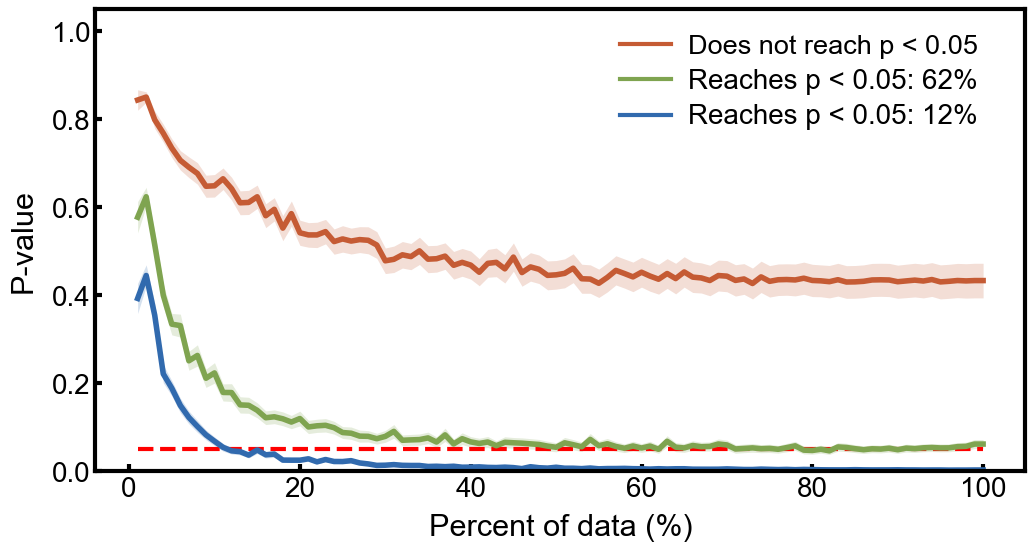

In [278]:
plot_same_noise_pvalues(pvalues, 0)

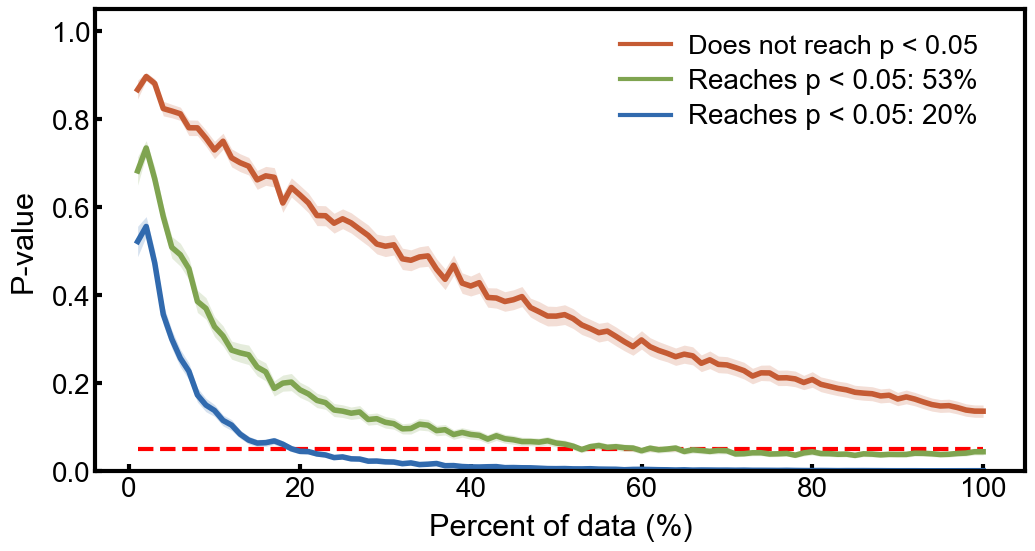

In [279]:
plot_same_noise_pvalues(pvalues, 1)

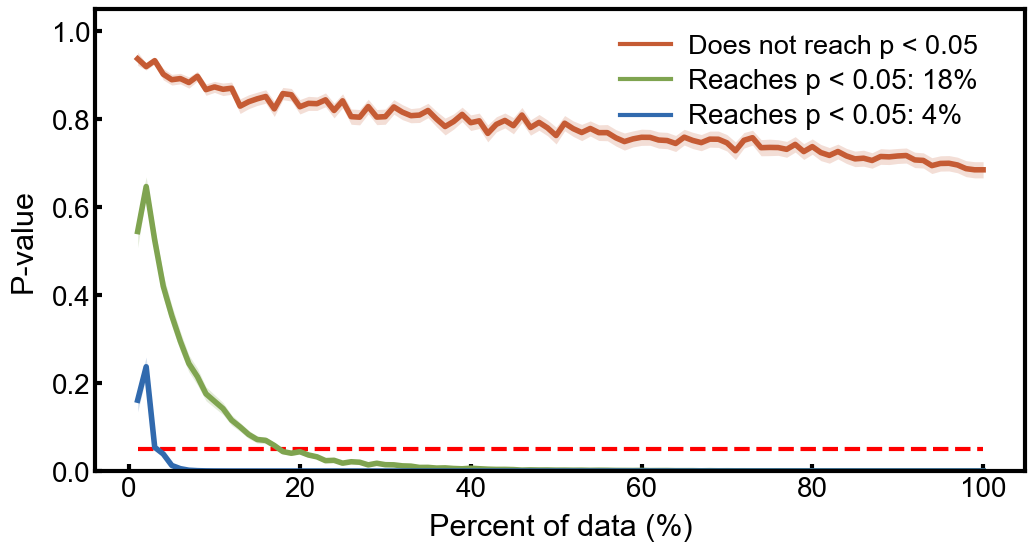

In [280]:
plot_same_noise_pvalues(pvalues, 2)

## Coverages

In [461]:
np.random.seed(42)
from scipy.stats import kstest

all_alphas = np.arange(0.01, 0.99, 0.01)
n_alphas = len(all_alphas)
n_iters = 100
n_classes = 4

empirical_coverages = np.zeros((3, 3, 9 * n_iters, n_alphas))
accuracies = np.zeros((3, 3, 9 * n_iters, n_alphas))
prediction_rates = np.zeros((3, 3, 9 * n_iters, n_alphas))

baseline_accuracy = np.zeros((3, 3, 9,))

strengths = [.05, .15, .25]
noise_funs = [add_gaussian_noise, add_impulse_noise, add_motion_artifacts]
sample_percentages = np.arange(0.01, 1.01, 0.01)
n_iters = 100
n_subjects = 9

for noise_i, noise_fun in tqdm(enumerate(noise_funs), total=3): 
    for strength_i, strength in tqdm(enumerate(strengths), total=3): 
        for subject_num in range(9): 
            model = all_models[subject_num]
            X_val = all_X_val[subject_num]; y_val = all_y_val[subject_num]
            X_test = all_X_test[subject_num]; y_test = all_y_test[subject_num]
            X_test_noisy = noise_fun(X_test, strength)
            val_smx = model.predict(X_val, verbose=False); test_smx = model.predict(X_test_noisy, verbose=False)
            
            for i_alpha, alpha in enumerate(all_alphas): 
                for i_iter in range(n_iters): 
                    save_idx = subject_num*n_iters + i_iter
                    pred_set, _ = conformalRAPS(val_smx, y_val, test_smx, alpha=alpha, lam_reg=.02, k_reg=1, rand=True, disallow_zero_sets=False)
                    empirical_coverages[noise_i, strength_i, save_idx, i_alpha] = get_coverage(y_test, pred_set)

                    pred_set, _ = conformalRAPS(val_smx, y_val, test_smx, alpha=alpha, lam_reg=.02, k_reg=1, rand=True, disallow_zero_sets=True)
                    set_size = get_set_size(pred_set, n_classes)
                    prediction_rates[noise_i, strength_i, save_idx, i_alpha] = (set_size[0] + set_size[1]) / sum(set_size.values())
                    accuracies[noise_i, strength_i, save_idx, i_alpha] = get_abstain_metrics(pred_set, test_smx, y_test, verbose=False)

            baseline_accuracy[noise_i, strength_i, subject_num] = np.mean(test_smx.argmax(1) == y_test.argmax(1))
    

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [462]:
save_path

'/Users/seonghyunyoon/Developer/conformal_prediction_bmi/test 5 (noise)/'

In [463]:
np.save(f'{save_path}baseline_accuracies.npy', baseline_accuracy)
np.save(f'{save_path}empirical_coverages.npy', empirical_coverages)
np.save(f'{save_path}accuracies.npy', accuracies)
np.save(f'{save_path}prediction_rates.npy', prediction_rates)

In [195]:
baseline_accuracy = np.load(f'{save_path}baseline_accuracies.npy')
empirical_coverages = np.load(f'{save_path}empirical_coverages.npy')
accuracies = np.load(f'{save_path}accuracies.npy')
prediction_rates = np.load(f'{save_path}prediction_rates.npy')

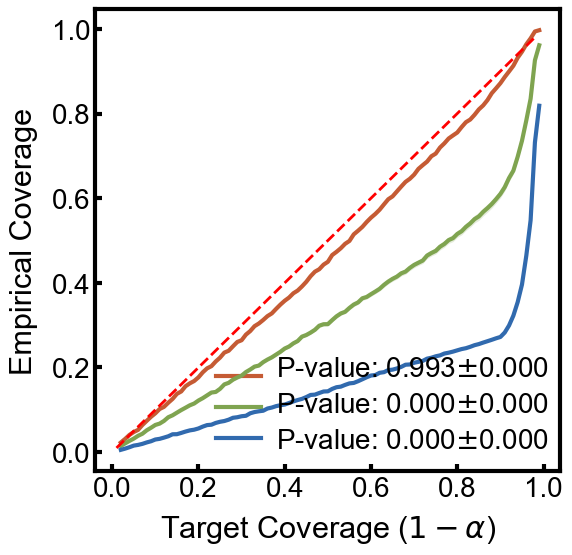

In [196]:
all_alphas = np.arange(0.01, 0.99, 0.01)
fig = plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'Arial'
n_i = 2 # 0 = gaussian, 1 = impulse, 2 = motion
color_i = [0, 2, 1]

for s_i in range(3): 
    avg, ci_lower, ci_upper = compute_ci_mean(empirical_coverages[n_i, s_i,...])
    plt.plot(1-all_alphas, avg, color=color_scheme[color_i[s_i]], linewidth=3)
    plt.fill_between(1-all_alphas, ci_lower, ci_upper, color=color_scheme[color_i[s_i]], alpha=.2, linewidth=0)
    pvalue = stats.kstest(1-all_alphas, avg, alternative='two-sided')[1]
    low_pvalue = stats.kstest(1-all_alphas, ci_lower, alternative='two-sided')[1]
    if pvalue > 0.999: 
        pvalue = 0.999
    plt.text(0.38, 0.18-0.085*s_i, fr'P-value: {pvalue:.3f}$\pm${np.abs(low_pvalue-pvalue):.3f}', fontsize=20, fontdict=dict(fontstretch = 'condensed'))
    plt.plot([0.24, 0.345], [0.1795-0.0735*s_i, 0.1795-0.0735*s_i], color=color_scheme[color_i[s_i]], linewidth=3)

plt.plot(all_alphas, all_alphas, 'r--', label='y=x', linewidth=2)  # 'k--' is for black dotted line
plt.grid(False)

plt.tick_params(axis='both',          # Applies to both x and y axis
                which='both',         # Applies to both major and minor ticks
                direction='in',       # Sets ticks to the inside
                bottom=True,          # Enables bottom ticks
                top=False,             # Enables top ticks
                left=True,            # Enables left ticks
                right=False)           # Enables right ticks
plt.tick_params(axis='both', length=5, width=3)

for spine in plt.gca().spines.values():
    spine.set_linewidth(3)  # Set the thickness here

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel(r'Target Coverage ($1-\alpha$)', fontsize=22, labelpad=8, fontdict=dict(fontstretch = 'condensed'))
plt.ylabel('Empirical Coverage', fontsize=22, labelpad=10)#, fontdict=dict(weight='bold'))

plt.show()

In [197]:
baseline_accuracy = np.load(f'{save_path}baseline_accuracies.npy')
empirical_coverages = np.load(f'{save_path}empirical_coverages.npy')
accuracies = np.load(f'{save_path}accuracies.npy')
prediction_rates = np.load(f'{save_path}prediction_rates.npy')

In [203]:
len(acc_imp)

1

In [253]:
alpha_max_list = [normalized_f1_score(acc_imp[i], prediction_rates_avg[i]) for i in range(3)] 

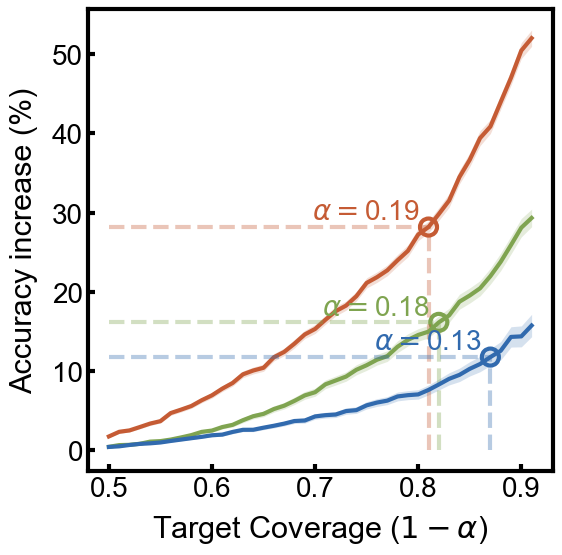

In [254]:
# alpha_max_list = [0,0,0]
all_alphas = np.arange(0.01, 0.99, 0.01)
plot_idx = np.logical_and(1-all_alphas <= 0.91, 1-all_alphas >= 0.50)
fig = plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'Arial'
n_i = 0 # 0 = gaussian, 1 = impulse, 2 = motion
color_i = [0, 2, 1]
n_iters = 100
acc_imp = []
y_adj = [3.5, 3.5, 3.5]

for s_i in range(3): 
    
    num = accuracies[n_i, s_i,...] - np.repeat(baseline_accuracy[n_i, s_i], n_iters)[:,None]
    denom = 1 - np.repeat(baseline_accuracy[n_i, s_i], n_iters)
    
    avg, ci_lower, ci_upper = compute_ci_mean(100 * num / denom[:,None])
    acc_imp.append(avg)
    plt.plot((1-all_alphas)[plot_idx], avg[plot_idx], color=color_scheme[color_i[s_i]], linewidth=3)
    plt.fill_between((1-all_alphas)[plot_idx], ci_lower[plot_idx], ci_upper[plot_idx], color=color_scheme[color_i[s_i]], alpha=.2, linewidth=0)
  
    alpha_max = (1-all_alphas)[plot_idx][alpha_max_list[s_i]]
    y_max = avg[plot_idx][alpha_max_list[s_i]]
    
    plt.plot([alpha_max, alpha_max], [0., y_max], '--', linewidth=3, color=color_scheme[color_i[s_i]], alpha=.35)
    plt.plot([0.5, alpha_max], [y_max, y_max], '--', linewidth=3, color=color_scheme[color_i[s_i]], alpha=.35)
    
    plt.text(alpha_max -0.009, y_max + y_adj[s_i], rf'$\alpha=${1-alpha_max:.2f}', verticalalignment='top', 
            horizontalalignment='right', fontsize=20, color=color_scheme[color_i[s_i]])
    plt.scatter(alpha_max, y_max, marker='o', s=150, color=color_scheme[color_i[s_i]], linewidths=3, facecolors='none')
    
plt.grid(False)

plt.tick_params(axis='both',          # Applies to both x and y axis
                which='both',         # Applies to both major and minor ticks
                direction='in',       # Sets ticks to the inside
                bottom=True,          # Enables bottom ticks
                top=False,             # Enables top ticks
                left=True,            # Enables left ticks
                right=False)           # Enables right ticks
plt.tick_params(axis='both', length=5, width=3)

for spine in plt.gca().spines.values():
    spine.set_linewidth(3)  # Set the thickness here

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel(r'Target Coverage ($1-\alpha$)', fontsize=22, labelpad=8, fontdict=dict(fontstretch = 'condensed'))
plt.ylabel('Accuracy increase (%)', fontsize=22, labelpad=10)#, fontdict=dict(weight='bold'))

plt.show()

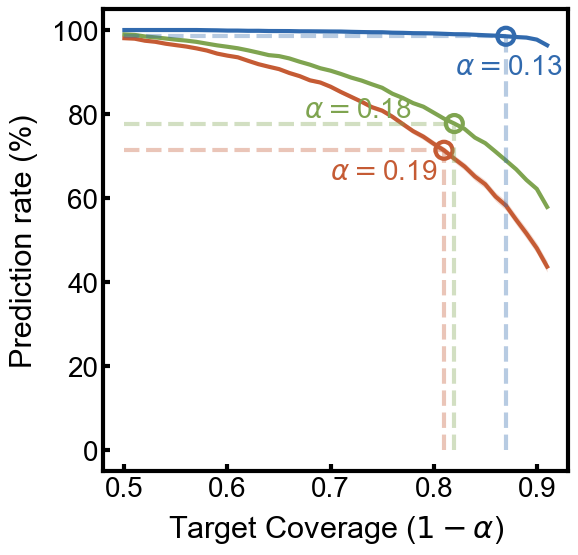

In [269]:
all_alphas = np.arange(0.01, 0.99, 0.01)
plot_idx = np.logical_and(1-all_alphas <= 0.91, 1-all_alphas >= 0.50)
fig = plt.figure(figsize=(7, 6))
plt.rcParams['font.family'] = 'Arial'
n_i = 2 # 0 = gaussian, 1 = impulse, 2 = motion
color_i = [0, 2, 1]
n_iters = 100
prediction_rates_avg = []
x_adj = [-0.007, -0.042, 0.055]
y_adj = [-2.2, 6.2, -4.2]

for s_i in range(3): 
    
    avg, ci_lower, ci_upper = compute_ci_mean(100 * prediction_rates[n_i, s_i])
    prediction_rates_avg.append(avg)
    plt.plot((1-all_alphas)[plot_idx], avg[plot_idx], color=color_scheme[color_i[s_i]], linewidth=3)
    plt.fill_between((1-all_alphas)[plot_idx], ci_lower[plot_idx], ci_upper[plot_idx], color=color_scheme[color_i[s_i]], alpha=.2, linewidth=0)

    alpha_max = (1-all_alphas)[plot_idx][alpha_max_list[s_i]]
    y_max = avg[plot_idx][alpha_max_list[s_i]]
    
    plt.plot([alpha_max, alpha_max], [0., y_max], '--', linewidth=3, color=color_scheme[color_i[s_i]], alpha=.35)
    plt.plot([0.5, alpha_max], [y_max, y_max], '--', linewidth=3, color=color_scheme[color_i[s_i]], alpha=.35)
    
    plt.text(alpha_max + x_adj[s_i], y_max + y_adj[s_i], rf'$\alpha=${1-alpha_max:.2f}', verticalalignment='top', 
            horizontalalignment='right', fontsize=20, color=color_scheme[color_i[s_i]], zorder=10)
    plt.scatter(alpha_max, y_max, marker='o', s=150, color=color_scheme[color_i[s_i]], linewidths=3, facecolors='none')
    

plt.grid(False)

plt.tick_params(axis='both',          # Applies to both x and y axis
                which='both',         # Applies to both major and minor ticks
                direction='in',       # Sets ticks to the inside
                bottom=True,          # Enables bottom ticks
                top=False,             # Enables top ticks
                left=True,            # Enables left ticks
                right=False)           # Enables right ticks
plt.tick_params(axis='both', length=5, width=3)

for spine in plt.gca().spines.values():
    spine.set_linewidth(3)  # Set the thickness here

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel(r'Target Coverage ($1-\alpha$)', fontsize=22, labelpad=8, fontdict=dict(fontstretch = 'condensed'))
plt.ylabel('Prediction rate (%)', fontsize=22, labelpad=10)#, fontdict=dict(weight='bold'))

plt.show()

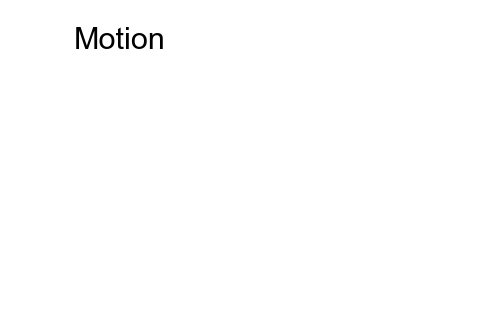

In [5]:
import matplotlib.pyplot as plt

# Define the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))
plt.rcParams['font.family'] = 'Arial'
# Hide the actual plot axes
ax.axis('off')

# Coordinates and labels for the custom legend
line_lengths = [0.02] * 9  # Length of each line
line_positions = range(9, 0, -1)  # Vertical positions of the lines
labels = ['Motion']
color_scheme_idx = [0, 2, 1]

# Plotting the lines and adding the labels
for i, (pos, length, label, color) in enumerate(zip(line_positions, line_lengths, labels, color_scheme_idx)):
    # Plot each line
    ax.plot([i*0.065, length+i*0.065], [9, 9], color=color_scheme[color], lw=0)
    # Add corresponding label
    ax.text(length + 0.0075+i*0.065, 9, label, verticalalignment='center', fontsize=22)

# Set the display limits to fit the custom legend
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 10)

plt.show()

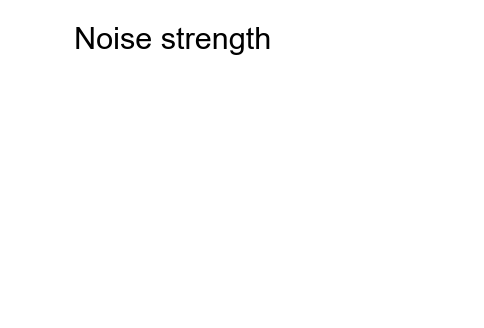

In [59]:
import matplotlib.pyplot as plt

# Define the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))
plt.rcParams['font.family'] = 'Arial'
# Hide the actual plot axes
ax.axis('off')

# Coordinates and labels for the custom legend
line_lengths = [0.02] * 9  # Length of each line
line_positions = range(9, 0, -1)  # Vertical positions of the lines
labels = ['Noise strength']
color_scheme_idx = [0, 2, 1]

# Plotting the lines and adding the labels
for i, (pos, length, label, color) in enumerate(zip(line_positions, line_lengths, labels, color_scheme_idx)):
    # Plot each line
    ax.plot([i*0.065, length+i*0.065], [9, 9], color=color_scheme[color], lw=0)
    # Add corresponding label
    ax.text(length + 0.0075+i*0.065, 9, label, verticalalignment='center', fontsize=22)

# Set the display limits to fit the custom legend
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 10)

plt.show()

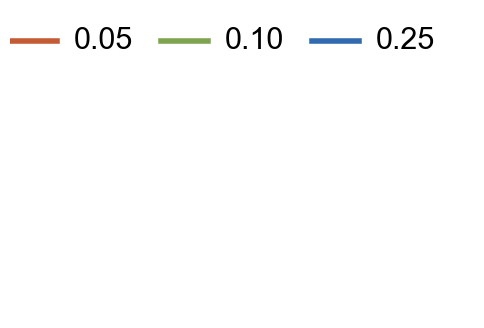

In [56]:
import matplotlib.pyplot as plt

# Define the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))
plt.rcParams['font.family'] = 'Arial'
# Hide the actual plot axes
ax.axis('off')

# Coordinates and labels for the custom legend
line_lengths = [0.02] * 9  # Length of each line
line_positions = range(9, 0, -1)  # Vertical positions of the lines
labels = ['0.05', '0.10', '0.25']
color_scheme_idx = [0, 2, 1]

# Plotting the lines and adding the labels
for i, (pos, length, label, color) in enumerate(zip(line_positions, line_lengths, labels, color_scheme_idx)):
    # Plot each line
    ax.plot([i*0.065, length+i*0.065], [9, 9], color=color_scheme[color], lw=4)
    # Add corresponding label
    ax.text(length + 0.0075+i*0.065, 9, label, verticalalignment='center', fontsize=22)

# Set the display limits to fit the custom legend
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 10)

plt.show()

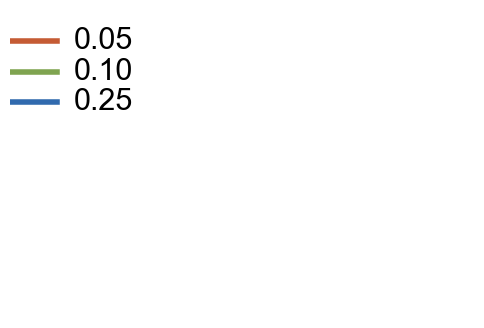

In [64]:
import matplotlib.pyplot as plt

# Define the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))
plt.rcParams['font.family'] = 'Arial'
# Hide the actual plot axes
ax.axis('off')

# Coordinates and labels for the custom legend
line_lengths = [0.02] * 9  # Length of each line
line_positions = range(9, 0, -1)  # Vertical positions of the lines
labels = ['0.05', '0.10', '0.25']
color_scheme_idx = [0, 2, 1]

# Plotting the lines and adding the labels
for i, (pos, length, label, color) in enumerate(zip(line_positions, line_lengths, labels, color_scheme_idx)):
    # Plot each line
    ax.plot([0, length], [pos, pos], color=color_scheme[color], lw=4)
    # Add corresponding label
    ax.text(length + 0.0075, pos, label, verticalalignment='center', fontsize=22)

# Set the display limits to fit the custom legend
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 10)

plt.show()

## Safety

In [ ]:
np.random.seed(42)
from scipy.stats import kstest

strengths = [.05, .15, .25]
noise_types = ["gaussian", "impulse", "motion"]
noise_funs = [add_gaussian_noise, add_impulse_noise, add_motion_artifacts]
sample_percentages = np.arange(0.01, 1.01, 0.01)
n_iters = 100
n_subjects = 9

pvalues = np.zeros((len(strengths), len(noise_types), n_subjects, len(sample_percentages), n_iters))
for i0, strength in tqdm(enumerate(strengths), total=3): 
    for i1, noise_fun in tqdm(enumerate(noise_funs), total=3): 
        for n_subject in range(n_subjects): 
            model = all_models[n_subject]
            X_val = all_X_val[n_subject]; y_val = all_y_val[n_subject]
            X_test = all_X_test[n_subject]; y_test = all_y_test[n_subject]
            X_test_noisy = noise_fun(X_test, strength=strength)
            val_smx = model.predict(X_val, verbose=False); test_smx = model.predict(X_test_noisy, verbose=False)
            n_test = X_test_noisy.shape[0]
            for i3, percentage in enumerate(sample_percentages): 
                curr_n_test = int(np.ceil(n_test * percentage))
                for i4 in range(n_iters): 
                    random_indices = np.random.choice(n_test, size=curr_n_test, replace=False)
                    val_score, test_score = get_conformity_scores(val_smx, y_val, test_smx[random_indices], y_test[random_indices])
                    pvalues[i0, i1, n_subject, i3, i4] = kstest(val_score, test_score)[1]
                    
np.save(f'{save_path}pvalues.npy', pvalues)

In [26]:
# True labels are treated as when the classifier gives us correct labels VS incorrect labels. 
# I.e., the CP abstaining framework is treated like a binary classifier on when to abstain or not. 

np.random.seed(42)

all_alphas = list(np.arange(0.01, 1.00, 0.01))

strengths = [.05, .15, .25]
noise_types = ["gaussian", "impulse", "motion"]
noise_funs = [add_gaussian_noise, add_impulse_noise, add_motion_artifacts]
n_iters = 50
true_positives = np.zeros((3, 3, 9, len(all_alphas), n_iters)); true_negatives = np.zeros((3, 3, 9, len(all_alphas), n_iters))
false_positives = np.zeros((3, 3, 9, len(all_alphas), n_iters)); false_negatives = np.zeros((3, 3, 9, len(all_alphas), n_iters))
baseline_accuracies = np.zeros((3, 3, 9,))

for noise_i, noise_fun in tqdm(enumerate(noise_funs), total=len(noise_funs)): 
    for strength_i, strength in tqdm(enumerate(strengths), total=len(strengths)): 
        for subject_num in tqdm(range(9), total=9): 
            model = all_models[subject_num]
            X_val = all_X_val[subject_num]; y_val = all_y_val[subject_num]
            X_test = all_X_test[subject_num]; y_test = all_y_test[subject_num]
            X_test_temp = []; y_test_temp = []
            for i in range(50): 
                X_test_temp.append(noise_fun(X_test, strength=strength))
                y_test_temp.append(y_test)
            X_test = np.vstack(X_test_temp); y_test = np.vstack(y_test_temp)
            val_smx = model.predict(X_val, verbose=False); test_smx = model.predict(X_test, verbose=False)
            true_abstain = test_smx.argmax(1) != y_test.argmax(1); true_noabstain = ~true_abstain
            baseline_accuracy = np.mean(true_noabstain)
            for i_alpha, alpha in enumerate(all_alphas): 
                for j in range(n_iters): 
                    ps, _ = conformalRAPS(val_smx, y_val, test_smx, alpha=1-alpha, lam_reg=.02, k_reg=1, rand=True, disallow_zero_sets=True, verbose=False)
                    pred_abstain = np.sum(ps, axis=1) > 1; pred_noabstain = np.sum(ps, axis=1) == 1
                    tp = np.sum(np.logical_and(pred_abstain, true_abstain)); fp = np.sum(np.logical_and(pred_abstain, true_noabstain))
                    fn = np.sum(np.logical_and(pred_noabstain, true_abstain)); tn = np.sum(np.logical_and(pred_noabstain, true_noabstain))
                    assert tp + fp + fn + tn == X_test.shape[0]
                            
                    true_positives[noise_i, strength_i, subject_num, i_alpha, j] = tp
                    true_negatives[noise_i, strength_i, subject_num, i_alpha, j] = tn
                    false_positives[noise_i, strength_i, subject_num, i_alpha, j] = fp
                    false_negatives[noise_i, strength_i, subject_num, i_alpha, j] = fn
            baseline_accuracies[noise_i, strength_i, subject_num] = baseline_accuracy

np.save(f'{save_path}true_positives.npy', true_positives)
np.save(f'{save_path}true_negatives.npy', true_negatives)
np.save(f'{save_path}false_positives.npy', false_positives)
np.save(f'{save_path}false_negatives.npy', false_negatives)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [270]:
true_positives[0, 0,...].shape

(9, 99, 50)

In [132]:
all_tpr = []; all_fpr = []; all_precision = []
for i in range(3): 
    temp_tpr = []; temp_fpr = []; temp_precision = []
    for j in range(3): 
        tpr, fpr, precision = compute_matrix_quantities(true_positives[i, j,...], true_negatives[i, j,...], false_positives[i, j,...], false_negatives[i, j,...])
        temp_tpr.append(np.expand_dims(tpr, 0)); temp_fpr.append(np.expand_dims(fpr, 0)); temp_precision.append(np.expand_dims(precision, 0))
    all_tpr.append(np.vstack(temp_tpr)); all_fpr.append(np.vstack(temp_fpr)); all_precision.append(np.vstack(temp_precision))

/Users/seonghyunyoon/Developer/conformal_prediction_bmi/plotting.py:682: RuntimeWarning: invalid value encountered in divide
  precision_array = true_positives[subject_num] / (true_positives[subject_num] + false_positives[subject_num])


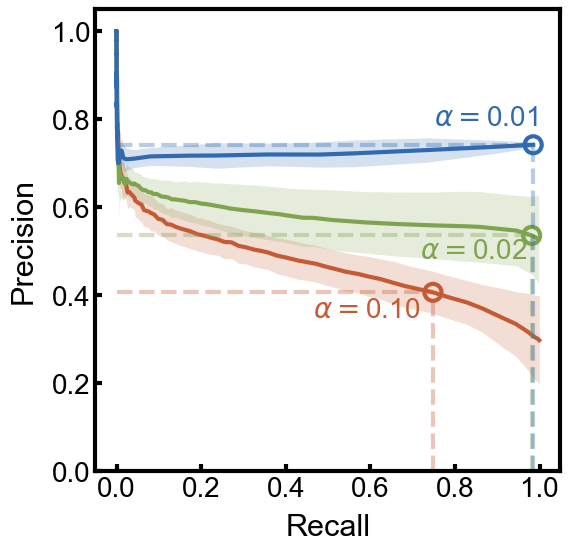

In [170]:
fig = plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'Arial'
color_i = [0, 2, 1]
x_adj = [-.03, -.01, 0.01]
y_adj = [-0.01, -0.005, 0.09]
y_area_adj = [0, 0.075]

tpr = all_tpr[2]  # 0 = Gaussian, 1 = impulse, 2 = motion 
precision = all_precision[2]

for i in range(3): 
    naive_precision = np.mean(1-baseline_accuracies[noise_i, i])
    tpr_mean, ci_lower_tpr, ci_upper_tpr = compute_ci_mean(tpr[i])
    precision_mean, ci_lower_pre, ci_upper_pre = compute_ci_mean(precision[i])
    sort_index = np.argsort(tpr_mean)
    f1_scores = 2 * (precision_mean * tpr_mean) / (precision_mean + tpr_mean)
    # Find the threshold that maximizes the F1 score
    max_f1_index = np.argmax(f1_scores)
    alpha_max = (1 - np.arange(0.01, 1.00, 0.01))[sort_index][max_f1_index]
    precision_max = precision_mean[max_f1_index]
    tpr_max = tpr_mean[max_f1_index]
    
    tpr_sorted = tpr_mean[sort_index]
    ci_lower_tpr = ci_lower_tpr[sort_index]
    ci_upper_tpr = ci_upper_tpr[sort_index]
    precision_sorted = precision_mean[sort_index]
    ci_lower_pre = ci_lower_pre[sort_index]
    ci_upper_pre = ci_upper_pre[sort_index]
    area = np.trapz(precision_sorted, tpr_sorted)
    area_lower = np.trapz(ci_lower_pre, tpr_sorted)
    
    # Plot 1: Target Coverage (x) & Empirical Coverage
    plt.plot(tpr_sorted, precision_sorted, color=color_scheme[color_i[i]], linewidth=3)
    plt.fill_between(tpr_sorted, ci_lower_pre, ci_upper_pre, color=color_scheme[color_i[i]], alpha=.2, linewidth=0)
    plt.text(tpr_max+x_adj[i], precision_max+y_adj[i], rf'$\alpha=${alpha_max:.2f}', verticalalignment='top', horizontalalignment='right', 
             fontsize=20, color=color_scheme[color_i[i]])
    plt.scatter(tpr_max, precision_max, marker='o', s=150, color=color_scheme[color_i[i]], linewidths=3, facecolors='none')
    
    plt.plot([tpr_max, tpr_max], [0, precision_max], '--', linewidth=3, color=color_scheme[color_i[i]], alpha=.35)
    plt.plot([np.min(tpr_sorted), tpr_max], [precision_max, precision_max], '--', linewidth=3, color=color_scheme[color_i[i]], alpha=.35)
    
    plt.grid(False)

    plt.tick_params(axis='both',          # Applies to both x and y axis
                    which='both',         # Applies to both major and minor ticks
                    direction='in',       # Sets ticks to the inside
                    bottom=True,          # Enables bottom ticks
                    top=False,             # Enables top ticks
                    left=True,            # Enables left ticks
                    right=False)           # Enables right ticks
    plt.tick_params(axis='both', length=5, width=3)
    
    for spine in plt.gca().spines.values():
        spine.set_linewidth(3)  # Set the thickness here


    # plt.text(0.45, 0.05+y_area_adj[i], rf'Area: {area:.3f}$\pm${(area-area_lower):.3f}', fontsize=20, fontdict=dict(fontstretch = 'condensed'))
    # plt.plot([0.32, 0.42], [0.068+y_area_adj[i], 0.068+y_area_adj[i]], color=color_scheme[color_i[i]], linewidth=3)
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(0, 1.05)
    plt.xlabel('Recall', fontsize=22, labelpad=8, fontdict=dict(fontstretch = 'condensed'))
    plt.ylabel('Precision', fontsize=22, labelpad=10)#, fontdict=dict(weight='bold'))
    
#plt.text(0.56, 0.2, rf'Baseline: {naive_precision:.3f}', fontsize=20, fontdict=dict(fontstretch = 'condensed'))
plt.show()

In [ ]:
#gaussian 
x_adj = [-.18, -.32, -0.01]
y_adj = [0.08, -0.03, 0.08]
y_area_adj = [0, 0.075, 0.075*2]

# Impulse
color_i = [0, 2, 1]
x_adj = [-0.07, -.02, -0.01]
y_adj = [-0.02, 0.07, 0.08]

(9, 99)

Area under the curve: 0.6885326411202144 $\plusminus$ 0.06424399766696265
Area under the curve: 0.5762065128293055 $\plusminus$ 0.0799431576803139
Area under the curve: 0.48058061921765993 $\plusminus$ 0.27010858759690015


<Figure size 600x600 with 0 Axes>

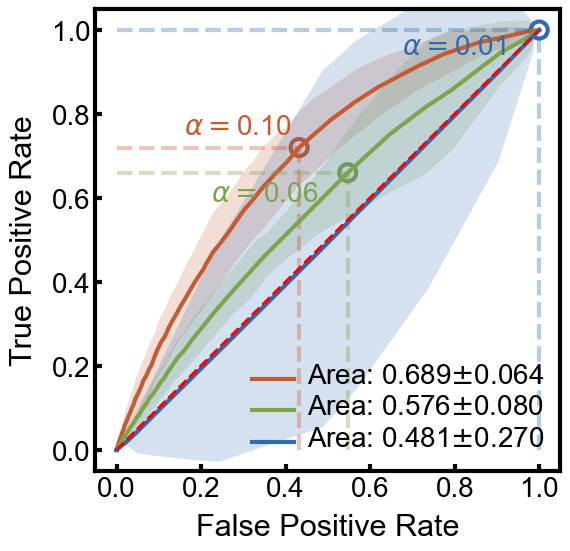

In [189]:
import matplotlib.patches as patches 

fig = plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'Arial'
color_i = [0, 2, 1]
x_adj = [-0.02, -0.07, -0.08]
y_adj = [0.08, -0.02, -0.01]
y_area_adj = [0, 0.075, 0.075*2]

fpr = all_fpr[2]  # 0 = Gaussian, 1 = impulse, 2 = motion 
tpr = all_tpr[2]

naive_precision = np.mean(1-baseline_accuracies)
fig = plt.figure(figsize=(6, 6))
clip_rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transData, edgecolor='none', facecolor='none')

for i in range(3): 
    fpr_mean, ci_lower_fpr, ci_upper_fpr = compute_ci_mean(fpr[i])
    tpr_mean, ci_lower_tpr, ci_upper_tpr = compute_ci_mean(tpr[i])

    sort_index = np.argsort(fpr_mean)
    tpr_sorted = np.insert(np.append(tpr_mean[sort_index], 1), 0, 0)
    fpr_sorted = np.insert(np.append(fpr_mean[sort_index], 1), 0, 0)
    ci_lower_fpr = ci_lower_fpr[sort_index]
    ci_upper_fpr = ci_upper_fpr[sort_index]
    ci_lower_tpr = ci_lower_tpr[sort_index]
    ci_upper_tpr = ci_upper_tpr[sort_index]

    j_index = tpr_sorted - fpr_sorted  # Youden's J statistic
    max_j_index = np.argmax(j_index)

    if max_j_index == 52: 
        max_j_index = 98
    alpha_max = (1 - np.arange(0.01, 1.00, 0.01))[sort_index][max_j_index]
    tpr_max = tpr_sorted[max_j_index]
    fpr_max = fpr_sorted[max_j_index]
    if max_j_index == 98: 
        tpr_max = 1; fpr_max= 1
        
    area = np.trapz(tpr_sorted[1:-1], fpr_sorted[1:-1])
    area_upper = np.trapz(ci_upper_tpr, fpr_sorted[1:-1])
    area_lower = np.trapz(ci_lower_tpr, fpr_sorted[1:-1])
    print(f"Area under the curve: {area} $\plusminus$ {area_upper-area}")


    plt.rcParams['font.family'] = 'Arial'
    plt.plot(fpr_sorted, tpr_sorted, color=color_scheme[color_i[i]], linewidth=3, clip_path=clip_rect)
    plt.fill_between(fpr_sorted[1:-1], ci_lower_tpr, ci_upper_tpr, color=color_scheme[color_i[i]], alpha=.2, linewidth=0, clip_path=clip_rect)

    plt.plot([0, 1], [0, 1], 'r--', label='y=x', linewidth=2, clip_path=clip_rect)  # 'k--' is for black dotted line
    
    plt.text(fpr_max+x_adj[i], tpr_max+y_adj[i], rf'$\alpha=${alpha_max:.2f}', verticalalignment='top', horizontalalignment='right', 
             fontsize=20, color=color_scheme[color_i[i]], zorder=2, clip_path=clip_rect)
    plt.scatter(fpr_max, tpr_max, marker='o', s=150, color=color_scheme[color_i[i]], linewidths=3, facecolors='none', clip_path=clip_rect)
    
    plt.plot([fpr_max, fpr_max], [0, tpr_max], '--', linewidth=3, color=color_scheme[color_i[i]], alpha=.35, clip_path=clip_rect)
    plt.plot([0, fpr_max], [tpr_max, tpr_max], '--', linewidth=3, color=color_scheme[color_i[i]], alpha=.35, clip_path=clip_rect)
    
    plt.grid(False)

    plt.tick_params(axis='both',          # Applies to both x and y axis
                    which='both',         # Applies to both major and minor ticks
                    direction='in',       # Sets ticks to the inside
                    bottom=True,          # Enables bottom ticks
                    top=False,             # Enables top ticks
                    left=True,            # Enables left ticks
                    right=False)           # Enables right ticks
    plt.tick_params(axis='both', length=5, width=3)

    for spine in plt.gca().spines.values():
        spine.set_linewidth(3)  # Set the thickness here

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.plot([0.32, 0.42], [0.17-y_area_adj[i], 0.17-y_area_adj[i]], color=color_scheme[color_i[i]], linewidth=3)
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    plt.xlabel('False Positive Rate', fontsize=22, labelpad=8, fontdict=dict(fontstretch = 'condensed'))
    plt.ylabel('True Positive Rate', fontsize=22, labelpad=10)#, fontdict=dict(weight='bold'))
    plt.text(0.45, 0.16-y_area_adj[i], rf'Area: {area:.3f}$\pm${(area-area_lower):.3f}', fontsize=20, fontdict=dict(fontstretch = 'condensed'))

plt.show()